<a href="https://colab.research.google.com/github/Julia891021/954/blob/main/hairstyle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install efficientnet_pytorch
!pip install torchvision
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=632153ce9329cb2b2527bfbd3409db2a9e64702dbadceebb8d9fa20f6d41b5aa
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 串接雲端硬碟

In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/954')

Mounted at /content/drive


### Import Library

In [4]:
# Check data directory
os.listdir("HairStyle Dataset")

['LongStraightFlat',
 'LongStraightOblique',
 'LongCurlyOblique',
 'ShortStraightFlat',
 'ShortStraightOblique',
 'ShortCurlyFlat',
 'ShortCurlyOblique',
 'LongCurlyFlat']

### Split train, val 

In [5]:
def split_train_val(data_dir, val_size=0.1, random_state=42):
    data=[]
    for dset in os.listdir(data_dir):  #dset:8種髮型
        # check is directory
        imgdir = os.path.join(data_dir, dset)
        if os.path.isdir(imgdir):
            for image_path in os.listdir(imgdir):
                if image_path.endswith(".jpeg"):
                    sample = {
                        "path": os.path.join(data_dir, dset, image_path),
                        "label": dset
                    }
                    data.append(sample)
    train, test = train_test_split(data, test_size=0.2, random_state=random_state)
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    train, val = train_test_split(train, test_size=val_size, random_state=random_state)
    # save to csv
#     train_path, val_path, test_path = os.path.join(data_dir, "train.csv"), os.path.join(data_dir, "val.csv"), os.path.join(data_dir, "test.csv")
#     train.to_csv(train_path, index=False)
#     val.to_csv(val_path, index=False)
#     test.to_csv(test_path, index=False)
    
    return train, val, test

train_df, val_df, test_df = split_train_val("HairStyle Dataset")
test_df

,path,label
0,HairStyle Dataset/ShortStraightOblique/Oblong4...,ShortStraightOblique
1,HairStyle Dataset/LongCurlyOblique/Round82.jpeg,LongCurlyOblique
2,HairStyle Dataset/LongStraightOblique/Oblong58...,LongStraightOblique
3,HairStyle Dataset/LongCurlyOblique/Oval88.jpeg,LongCurlyOblique
4,HairStyle Dataset/LongStraightOblique/Round38....,LongStraightOblique
...,...,...
680,HairStyle Dataset/LongCurlyOblique/Round147.jpeg,LongCurlyOblique
681,HairStyle Dataset/LongStraightOblique/Square10...,LongStraightOblique
682,HairStyle Dataset/LongCurlyOblique/Square55.jpeg,LongCurlyOblique
683,HairStyle Dataset/ShortStraightOblique/Oblong1...,ShortStraightOblique


### Visualize some images and labels

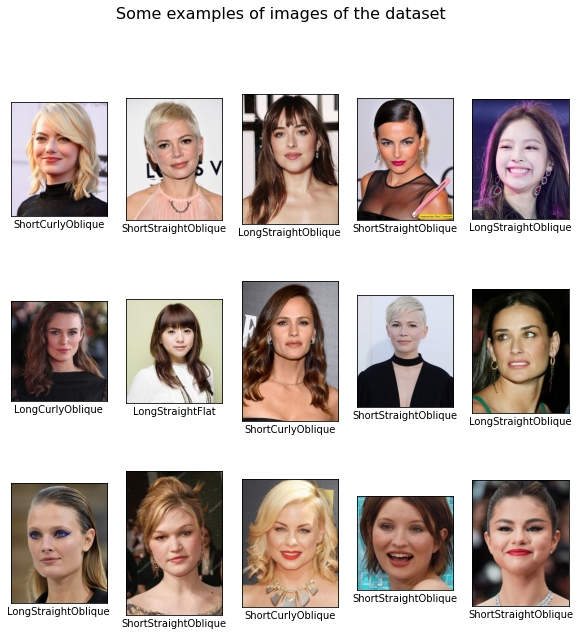

In [6]:
import cv2
import matplotlib.pyplot as plt  

def display_examples():
    
    """
        Display 15 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = train_df.iloc[i]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(train_df.iloc[i]["label"])
    plt.show()

display_examples()


### Dataset

In [7]:
# Dataset
class HairStyleDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, split="train"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.split = split
        class_names = ['LongCurlyOblique','LongStraightFlat','LongStraightOblique','ShortStraightFlat','ShortStraightOblique','ShortCurlyFlat','ShortCurlyOblique','LongCurlyFlat']
        self.label2idx = {class_name:i for i, class_name in enumerate(class_names)}
        self.idx2label = {v:k for k,v in self.label2idx.items()}
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)
            
            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)
        except:
            print(f"Error load image {img_path}")
            idx = 0
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)
            
            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)

### EfficientNet

In [8]:
# Models
class EffNet(nn.Module):
    def __init__(self, num_classes=8):
        super(EffNet, self).__init__()
        self.eff = EfficientNet.from_pretrained('efficientnet-b5', num_classes=num_classes, in_channels=1)
    def forward(self, x):
        x = self.eff(x)
        return x

In [9]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    best_accuracy = 0
    for epoch in range(epochs):
        model.train()
        bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Epoch {}".format(epoch+1))
        for batch_idx, (data, target) in bar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            bar.set_postfix(loss=loss.item())
        
        model.eval()
        val_loss = 0
        correct = 0
        
        with torch.no_grad():
            bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation Epoch {}".format(epoch+1))
            for batch_idx, (data, target) in bar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100. * correct / len(val_loader.dataset)
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            val_accuracy))
        
        # save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "./best_hairstyle_model.pth")
            print("Saved best hairstyle model")
        print("Best accuracy: {}".format(best_accuracy))

    return model

In [10]:
# Configs
class args:
    data_dir="HairStyle Dataset"
    batch_size=10
    n_epochs=20
    learning_rate=0.001
    debug=False

In [11]:
train_df, val_df, test_df = split_train_val(args.data_dir)
if args.debug:
    train_df, val_df = train_df.sample(n=10).reset_index(drop=True), val_df.sample(n=10).reset_index(drop=True)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_loader = torch.utils.data.DataLoader(
    HairStyleDataset(train_df, transform=transform, split="train"),
    batch_size=args.batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    HairStyleDataset(val_df, transform=transform, split="val"),
    batch_size=args.batch_size, shuffle=False
)

### Start Training



In [12]:
# import time
# from datetime import timedelta
# st = time.time()
# print("-------- Start training --------")
# model = EffNet().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
# model = train(model, train_loader, val_loader, criterion, optimizer, epochs=args.n_epochs, device=device)
# print("-------- End training, time taken:", timedelta(seconds=int(time.time()-st)))

-------- Start training --------


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b5


Training Epoch 1:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.2855, Accuracy: 160/274 (58%)

Saved best hairstyle model
Best accuracy: 58.394160583941606


Training Epoch 2:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.4088, Accuracy: 167/274 (61%)

Saved best hairstyle model
Best accuracy: 60.948905109489054


Training Epoch 3:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.2761, Accuracy: 169/274 (62%)

Saved best hairstyle model
Best accuracy: 61.67883211678832


Training Epoch 4:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.4511, Accuracy: 172/274 (63%)

Saved best hairstyle model
Best accuracy: 62.77372262773723


Training Epoch 5:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 0.9116, Accuracy: 192/274 (70%)

Saved best hairstyle model
Best accuracy: 70.07299270072993


Training Epoch 6:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.2295, Accuracy: 174/274 (64%)

Best accuracy: 70.07299270072993


Training Epoch 7:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.1954, Accuracy: 183/274 (67%)

Best accuracy: 70.07299270072993


Training Epoch 8:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.3456, Accuracy: 184/274 (67%)

Best accuracy: 70.07299270072993


Training Epoch 9:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.6914, Accuracy: 166/274 (61%)

Best accuracy: 70.07299270072993


Training Epoch 10:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.6768, Accuracy: 161/274 (59%)

Best accuracy: 70.07299270072993


Training Epoch 11:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.4395, Accuracy: 175/274 (64%)

Best accuracy: 70.07299270072993


Training Epoch 12:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.7336, Accuracy: 166/274 (61%)

Best accuracy: 70.07299270072993


Training Epoch 13:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 13:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.3992, Accuracy: 187/274 (68%)

Best accuracy: 70.07299270072993


Training Epoch 14:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 14:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.3003, Accuracy: 184/274 (67%)

Best accuracy: 70.07299270072993


Training Epoch 15:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 15:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.6473, Accuracy: 184/274 (67%)

Best accuracy: 70.07299270072993


Training Epoch 16:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 16:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.4832, Accuracy: 172/274 (63%)

Best accuracy: 70.07299270072993


Training Epoch 17:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 17:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 2.0403, Accuracy: 161/274 (59%)

Best accuracy: 70.07299270072993


Training Epoch 18:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 18:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.8891, Accuracy: 184/274 (67%)

Best accuracy: 70.07299270072993


Training Epoch 19:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 19:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.6919, Accuracy: 185/274 (68%)

Best accuracy: 70.07299270072993


Training Epoch 20:   0%|          | 0/247 [00:00<?, ?it/s]

Validation Epoch 20:   0%|          | 0/28 [00:00<?, ?it/s]


Validation set: Average loss: 1.7802, Accuracy: 173/274 (63%)

Best accuracy: 70.07299270072993
-------- End training, time taken: 7:57:26


### Load Pretrined model

In [13]:
path = '/content/drive/Shareddrives/954/best_hairstyle_model.pth'
model = EffNet().to(device)
model.load_state_dict(torch.load(path))

### Predict on test set

In [14]:
test_ds = HairStyleDataset(test_df, transform=transform, split="test")
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=args.batch_size, shuffle=False
)
model.eval()
test_loss = 0
correct = 0
y_true = []
y_pred = []
prob_list = []
with torch.no_grad():
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.cross_entropy(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
      y_true += target.view(-1).tolist()
      y_pred += pred.view(-1).tolist()
        
test_loss /= len(test_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

y_true = [test_ds.idx2label[i] for i in y_true]
y_pred = [test_ds.idx2label[i] for i in y_pred]
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


Test set: Average loss: 1.4886, Accuracy: 470/685 (69%)

                      precision    recall  f1-score   support

       LongCurlyFlat       0.31      0.42      0.36        12
    LongCurlyOblique       0.71      0.76      0.73       208
    LongStraightFlat       0.83      0.71      0.77        21
 LongStraightOblique       0.67      0.68      0.68       144
      ShortCurlyFlat       0.33      0.33      0.33        12
   ShortCurlyOblique       0.65      0.62      0.63        84
   ShortStraightFlat       0.53      0.67      0.59        36
ShortStraightOblique       0.79      0.67      0.73       168

            accuracy                           0.69       685
           macro avg       0.60      0.61      0.60       685
        weighted avg       0.69      0.69      0.69       685



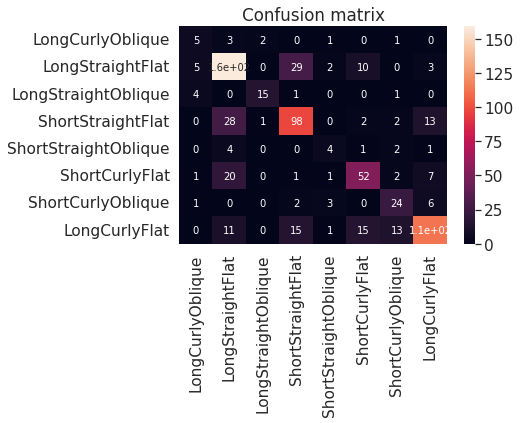

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

CM = confusion_matrix(y_true, y_pred)
class_names = list(test_ds.label2idx.keys())
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

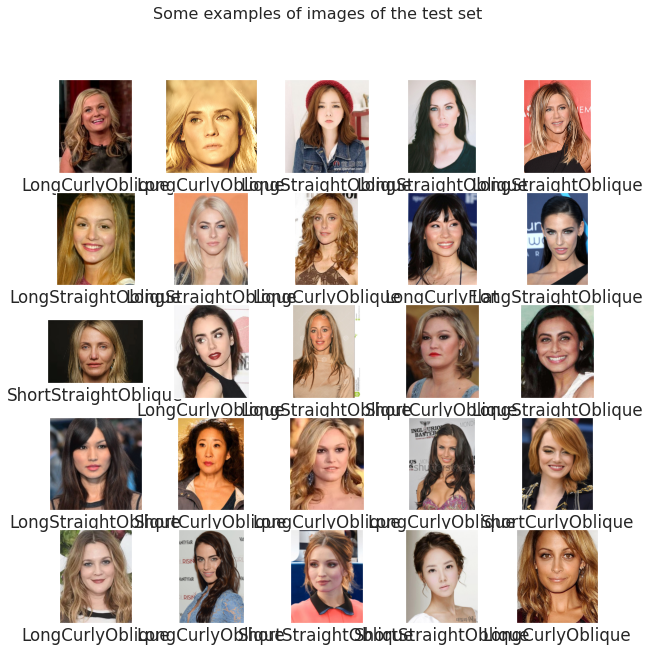

In [16]:
import cv2
import matplotlib.pyplot as plt
from random import randint

list_idx = [randint(0, len(test_ds)) for i in range(25)]

def display_examples():
    
    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the test set", fontsize=16)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = test_ds.df.iloc[idx]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y_true[idx])
    plt.show()

display_examples()


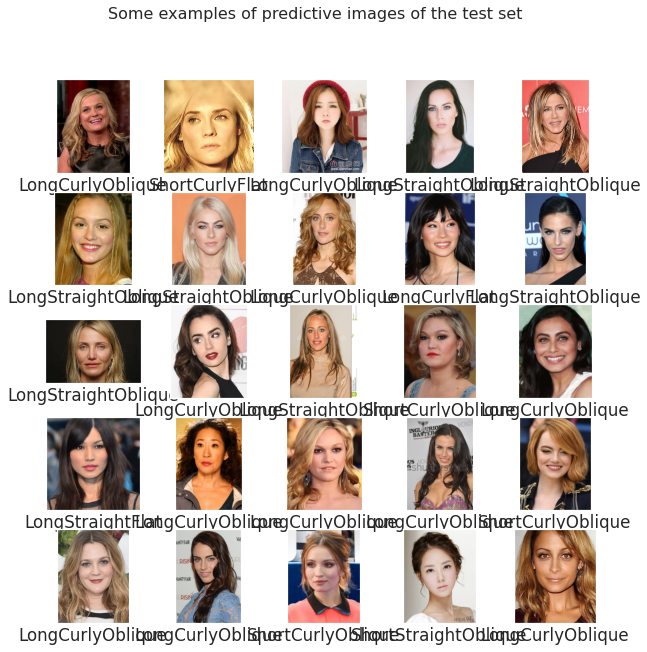

In [17]:
def display_examples():
    
    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of predictive images of the test set", fontsize=16)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = test_ds.df.iloc[idx]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y_pred[idx])
    plt.show()

display_examples()